<a href="https://www.kaggle.com/code/aleksandrmorozov123/video-detection-algorithms?scriptVersionId=194005979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Instance segmentation**

In [1]:
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
!wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
!tar -xf images.tar
!tar -xf annotations_instance.tar
!rm images.tar annotations_instance.tar
!pip install -qU torch_snippets
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.1.6 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [18]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [19]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).float().to(device)
        self.y = torch.tensor(y).float().to(device)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    def __len__(self): 
        return len(self.x)
    
ds = MyDataset(x, y)
dl = DataLoader(ds, batch_size=2, shuffle=True)

NameError: name 'y' is not defined

In [20]:
from torch_snippets import *
from torch_snippets.inspector import inspect
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

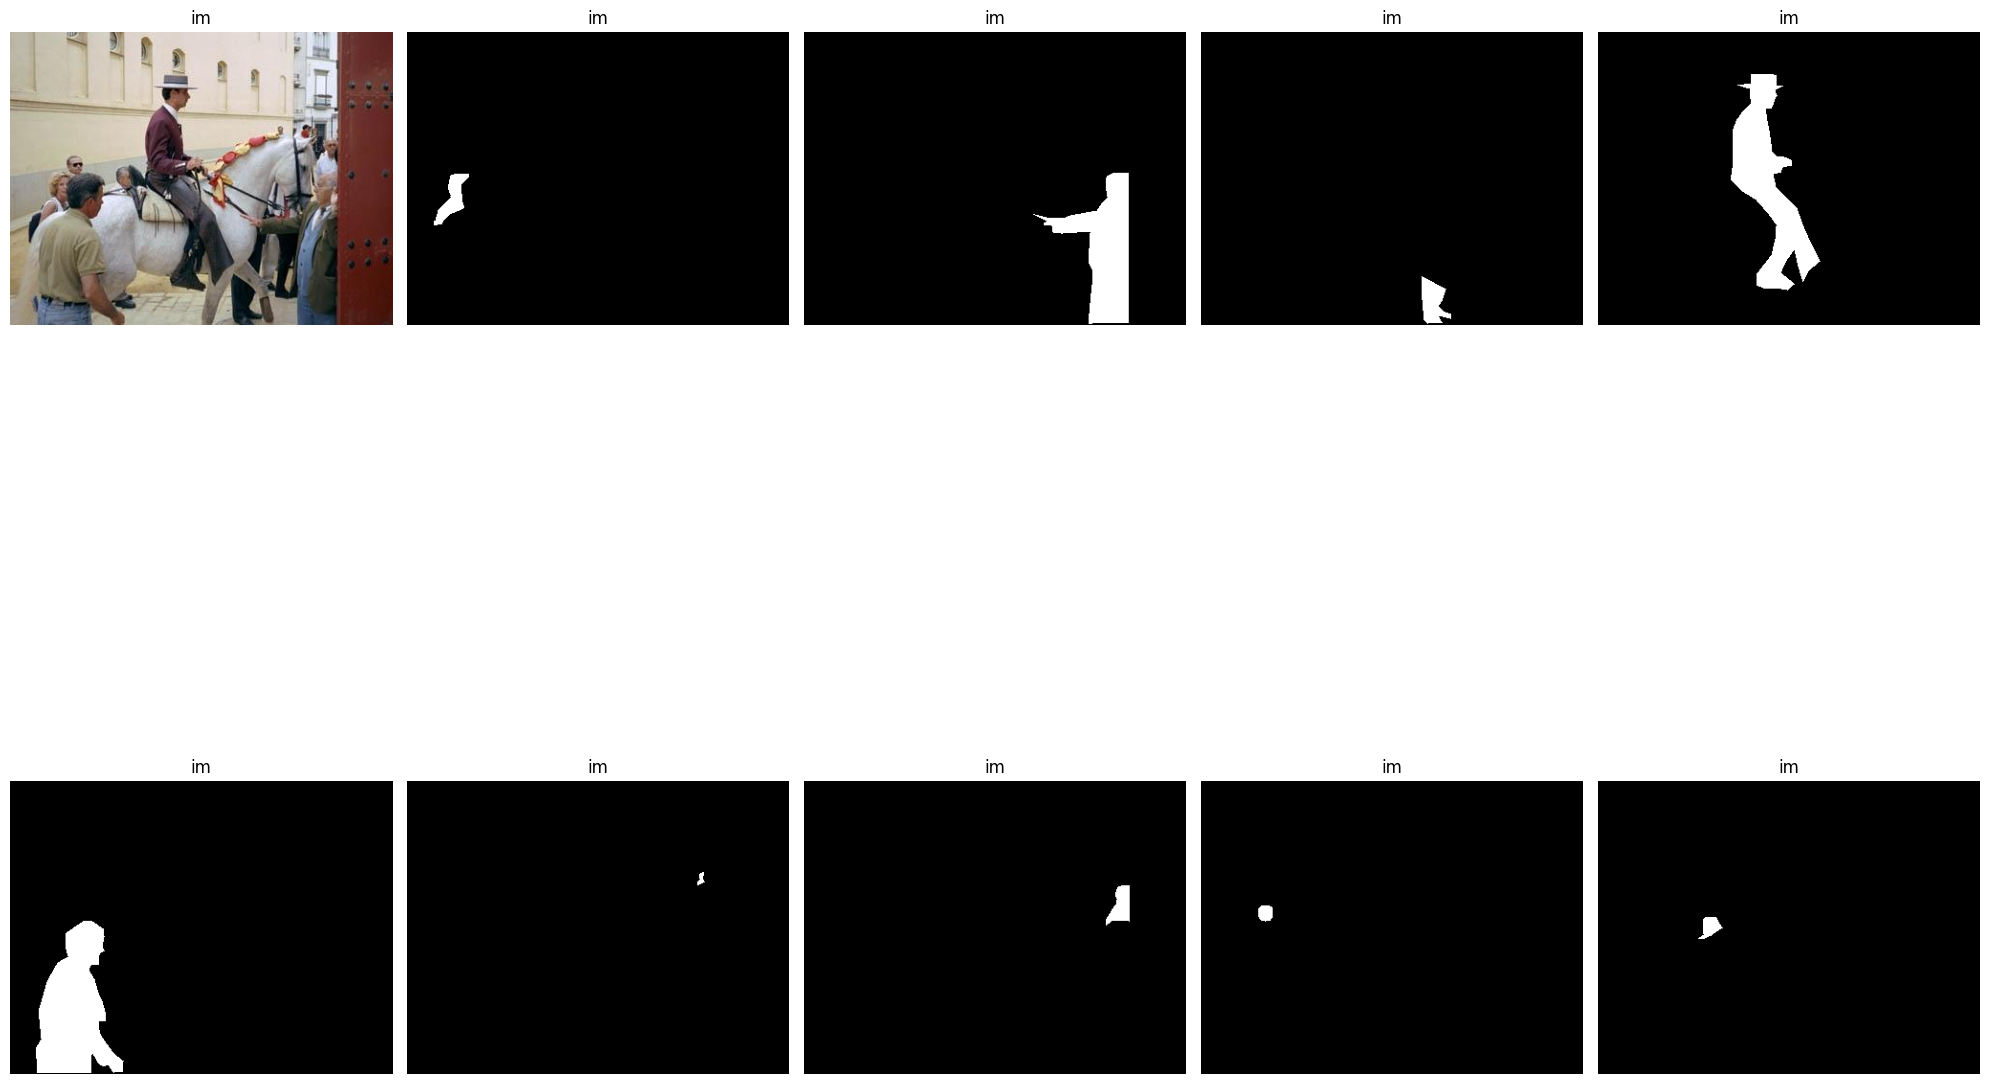

In [7]:
f = 'ADE_train_00014303'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [8]:
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 5000/5000 [00:27<00:00, 183.52it/s]


In [22]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [23]:
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [24]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8):
            img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]
    
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

══════════════════════════════════════════════════════════════════


NameError: name 'torch' is not defined

In [25]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

══════════════════════════════════════════════════════════════════


NameError: name 'torch' is not defined

In [26]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [27]:
model = get_model_instance_segmentation(2).to(device)
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 161MB/s]  


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [28]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [29]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [30]:
num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset 
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/462]  eta: 0:16:05  lr: 0.000016  loss: 4.3031 (4.3031)  loss_classifier: 0.4570 (0.4570)  loss_box_reg: 0.1827 (0.1827)  loss_mask: 3.6468 (3.6468)  loss_objectness: 0.0155 (0.0155)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 2.0908  data: 0.0338  max mem: 2325
Epoch: [0]  [ 10/462]  eta: 0:05:43  lr: 0.000124  loss: 3.9175 (3.7349)  loss_classifier: 0.4983 (0.4792)  loss_box_reg: 0.4584 (0.3771)  loss_mask: 2.9090 (2.7915)  loss_objectness: 0.0562 (0.0616)  loss_rpn_box_reg: 0.0077 (0.0254)  time: 0.7598  data: 0.0599  max mem: 3471
Epoch: [0]  [ 20/462]  eta: 0:05:11  lr: 0.000233  loss: 1.9524 (2.7591)  loss_classifier: 0.3993 (0.4225)  loss_box_reg: 0.4709 (0.4135)  loss_mask: 1.1973 (1.8480)  loss_objectness: 0.0449 (0.0521)  loss_rpn_box_reg: 0.0128 (0.0229)  time: 0.6346  data: 0.0625  max mem: 3536
Epoch: [0]  [ 30/462]  eta: 0:04:41  lr: 0.000341  loss: 1.3578 (2.1881)  loss_classifier: 0.3104 (0.3500)  loss_box_reg: 0.2687 (0.3563)  loss_mask: 0.6688 (1.4087) 

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

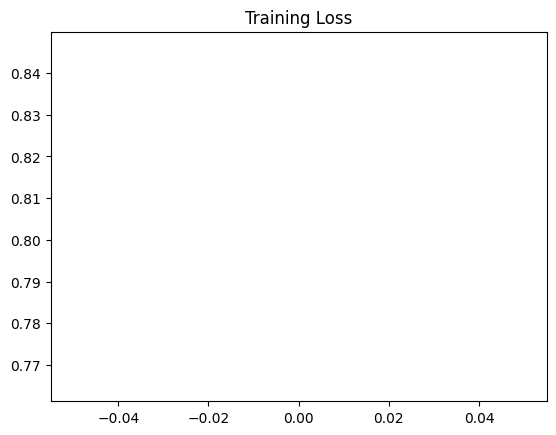

In [31]:
import matplotlib.pyplot as plt
plt.title('Training Loss') 
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

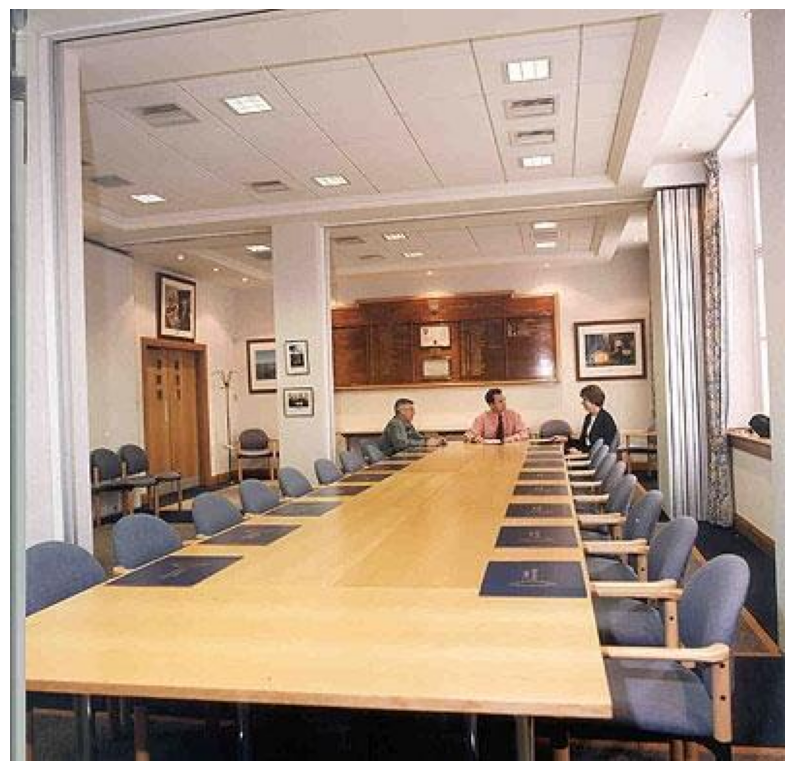

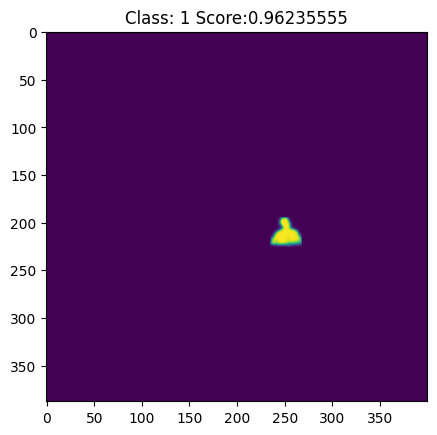

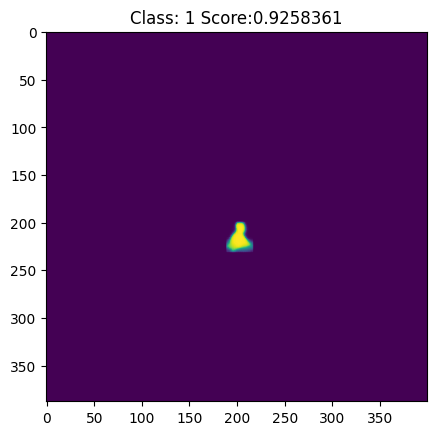

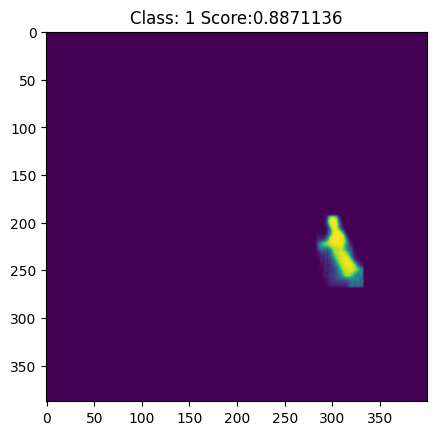

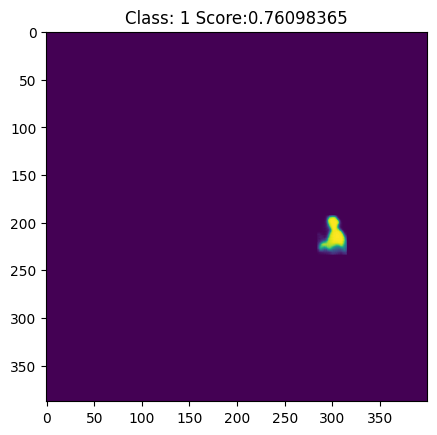

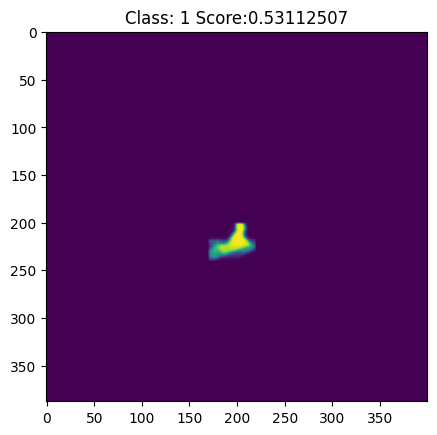

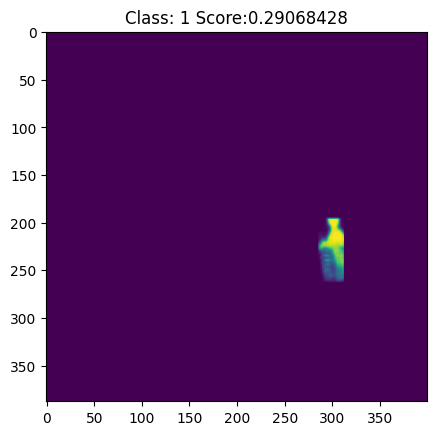

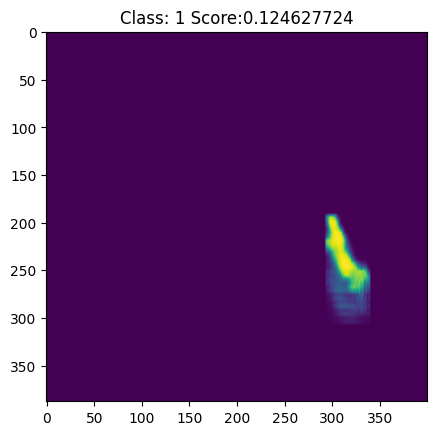

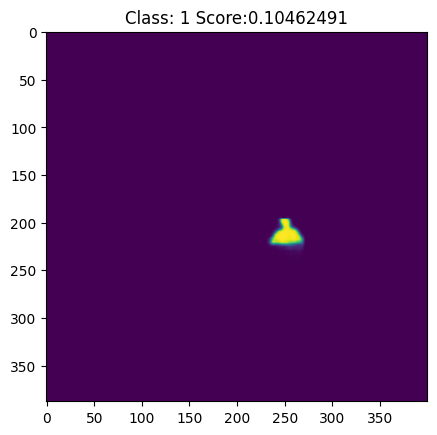

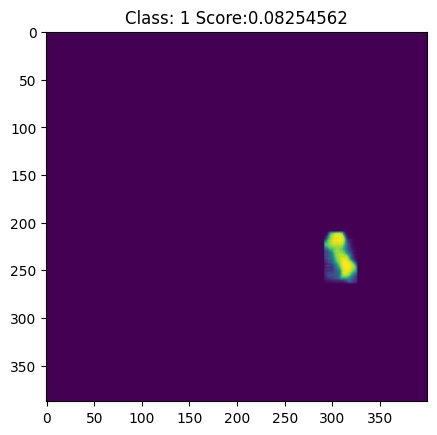

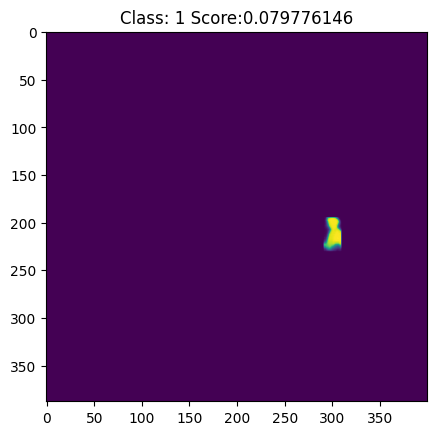

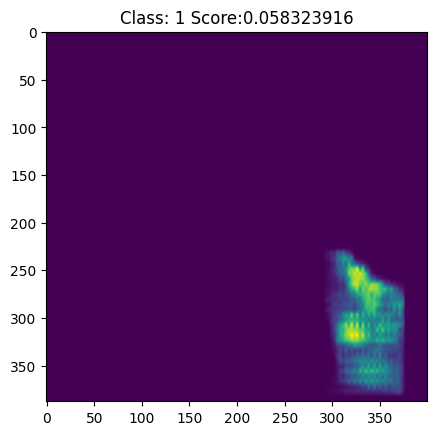

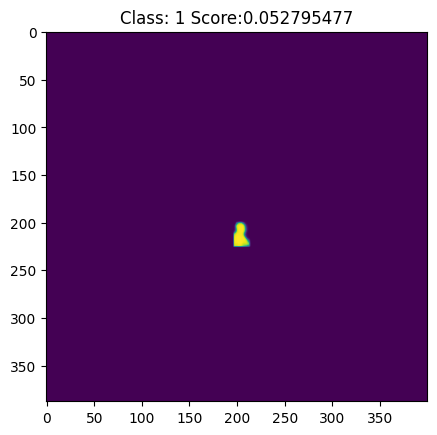

In [35]:
model.eval()
im = dataset_test[6][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()

**Prediction multiple instances of multiple classes**

In [36]:
classes_list = [4,6]
annots = []
for ann in Tqdm(all_annots):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if np.array([num in np.unique(r) for num in classes_list]).sum()==0: continue
    annots.append(ann)
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

100%|██████████| 20210/20210 [02:56<00:00, 114.29it/s]


In [37]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [38]:
def get_mask(path):
    an = read(path, 1).transpose(2,0,1)
    r,g,b = an
    cls = list(set(np.unique(r)).intersection({4,6}))
    print(cls)
    masks = []
    labels = []
    for _cls in cls:
      nzs = np.nonzero(r==_cls)
      instances = np.unique(g[nzs])
      for ix,_id in enumerate(instances):
          masks.append(g==_id)
          labels.append(classes_list.index(_cls)+1)
    return np.array(masks), np.array(labels)

In [39]:
_id = trn_items[11]
img_path = f'images/training/{_id}.jpg'

In [40]:
get_mask(img_path)

[4, 6]


(array([[[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],
 
        [[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, 

In [41]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self,path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        cls = list(set(np.unique(r)).intersection({4,6}))
        masks = []
        labels = []
        for _cls in cls:
          nzs = np.nonzero(r==_cls)
          instances = np.unique(g[nzs])
          for ix,_id in enumerate(instances):
              masks.append(g==_id)
              labels.append(classes_list.index(_cls)+1)
        return np.array(masks), np.array(labels)
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks, labels = self.get_mask(mask_path)
        #print(labels)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8):
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[1]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

══════════════════════════════════════════════════════════════════


NameError: name 'torch' is not defined

In [42]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [43]:
model = get_model_instance_segmentation(3).to(device)

In [44]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=3000)
dataset_test = MasksDataset(val_items, get_transform(train=False), N=800)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [45]:
num_classes = 3
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [46]:
model.eval()
pred = model(dataset[0][0][None].to(device))
inspect(pred[0])

══════════════════════════════════════════════════════════════════
dict of 4 items


NameError: name 'torch' is not defined

In [47]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [   0/1500]  eta: 0:18:22  lr: 0.000010  loss: 4.3490 (4.3490)  loss_classifier: 1.2809 (1.2809)  loss_box_reg: 0.4304 (0.4304)  loss_mask: 2.5186 (2.5186)  loss_objectness: 0.0601 (0.0601)  loss_rpn_box_reg: 0.0590 (0.0590)  time: 0.7353  data: 0.0575  max mem: 4137
Epoch: [0]  [  10/1500]  eta: 0:16:38  lr: 0.000060  loss: 3.8365 (4.1622)  loss_classifier: 1.2809 (1.2632)  loss_box_reg: 0.2746 (0.3043)  loss_mask: 2.3362 (2.5352)  loss_objectness: 0.0370 (0.0370)  loss_rpn_box_reg: 0.0150 (0.0226)  time: 0.6703  data: 0.0309  max mem: 4620
Epoch: [0]  [  20/1500]  eta: 0:16:34  lr: 0.000110  loss: 3.3987 (3.3793)  loss_classifier: 1.0146 (1.0164)  loss_box_reg: 0.2508 (0.2921)  loss_mask: 1.9547 (2.0123)  loss_objectness: 0.0337 (0.0386)  loss_rpn_box_reg: 0.0100 (0.0199)  time: 0.6687  data: 0.0269  max mem: 4629
Epoch: [0]  [  30/1500]  eta: 0:16:25  lr: 0.000160  loss: 1.9077 (2.7733)  loss_classifier: 0.4566 (0.7880)  loss_box_reg: 0.1624 (0.2641)  loss_mask: 1.0211 (

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

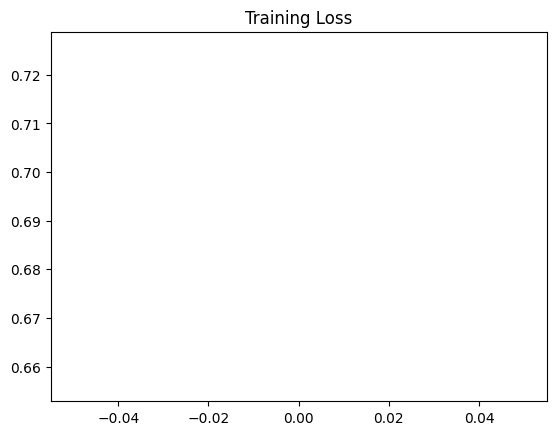

In [48]:
import matplotlib.pyplot as plt
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

In [51]:
k=408

In [52]:
k

408

In [53]:
k=423

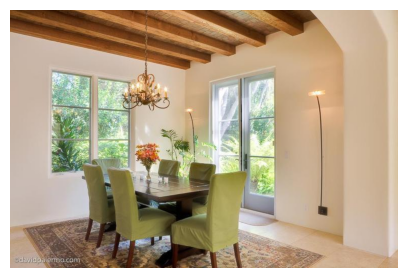

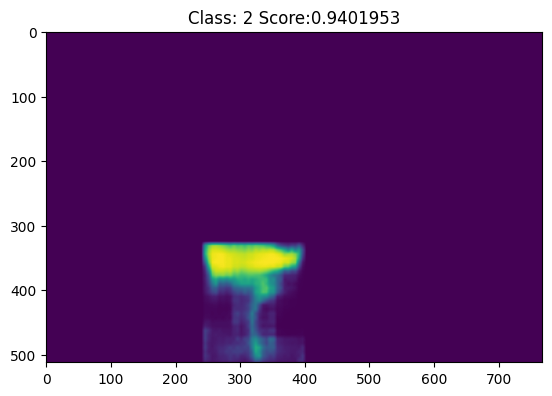

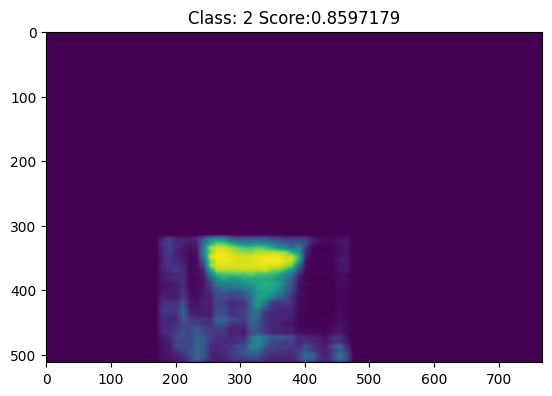

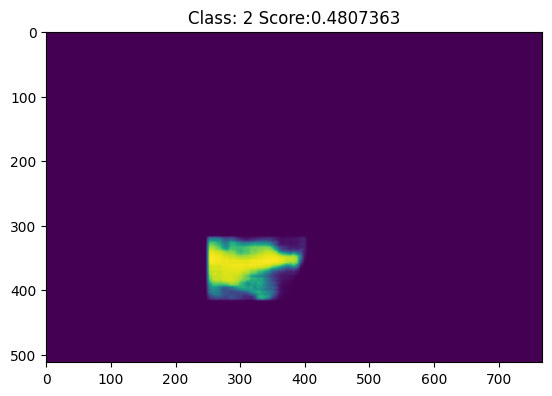

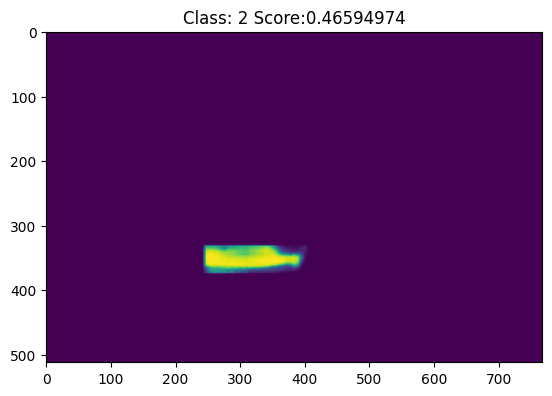

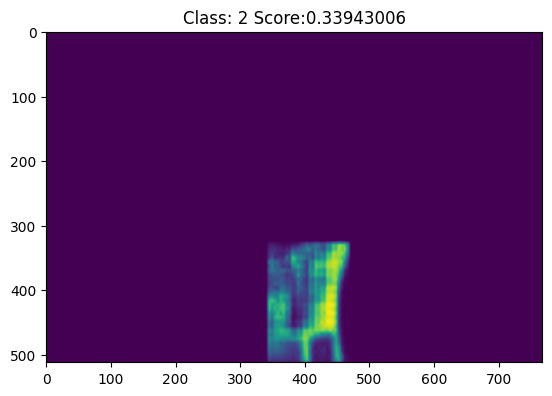

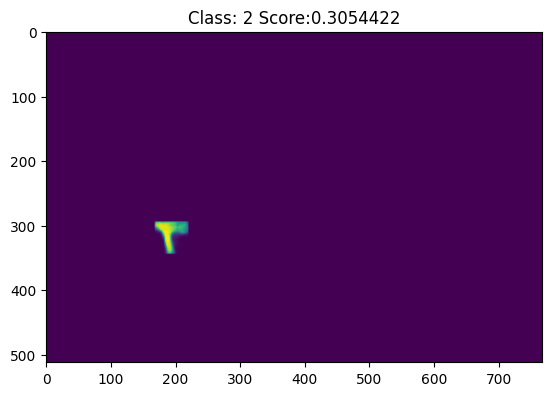

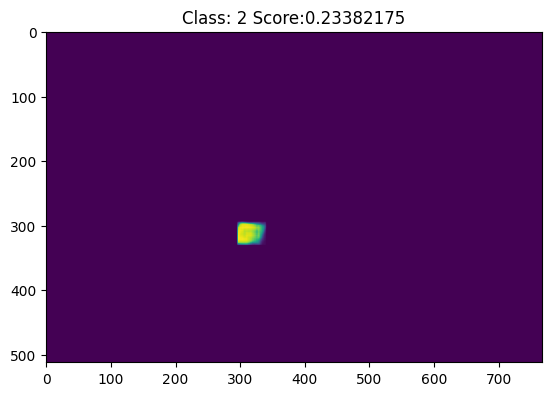

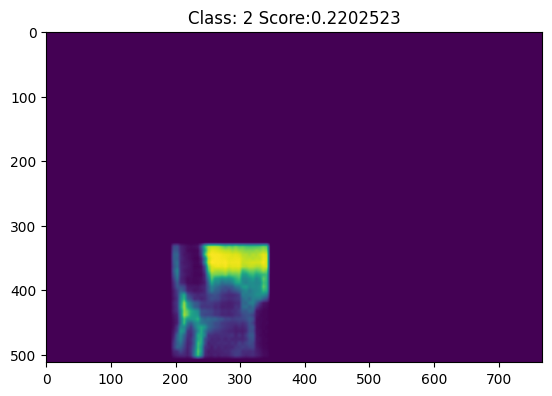

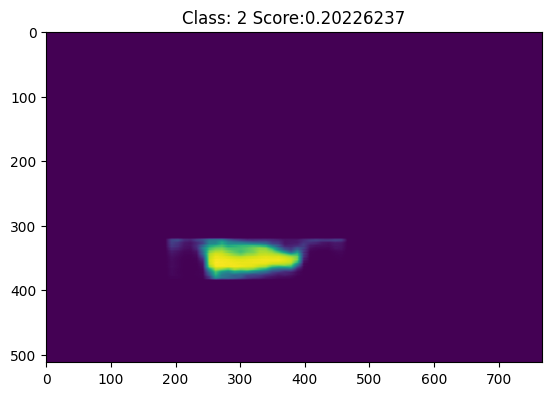

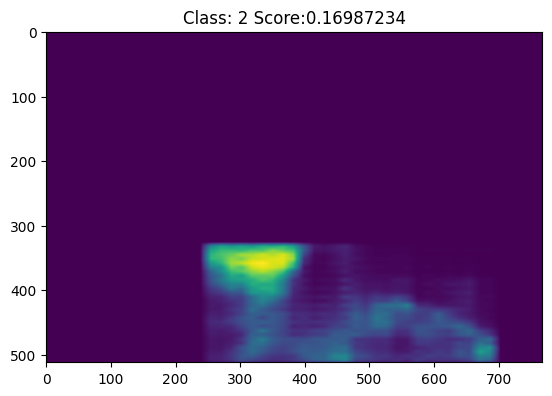

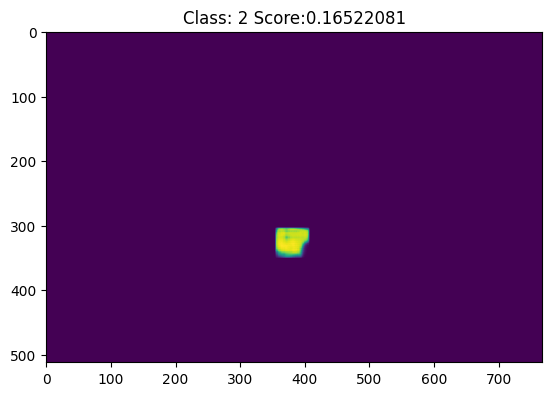

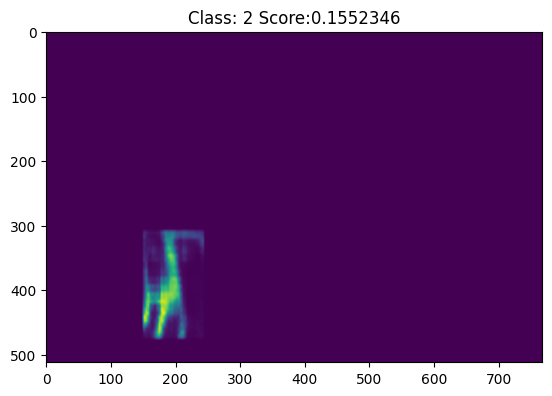

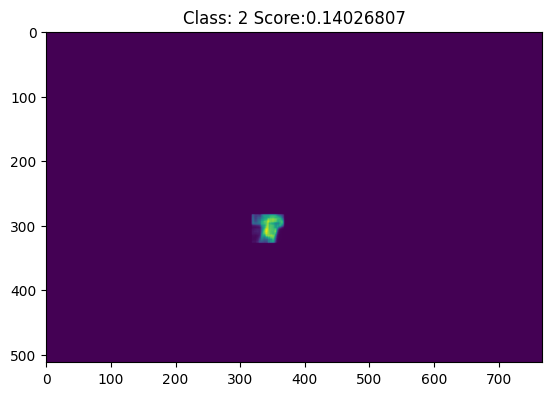

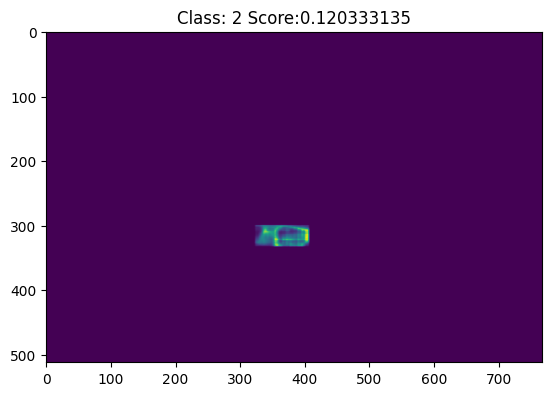

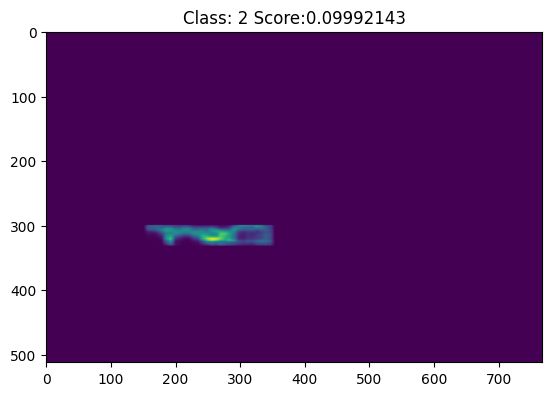

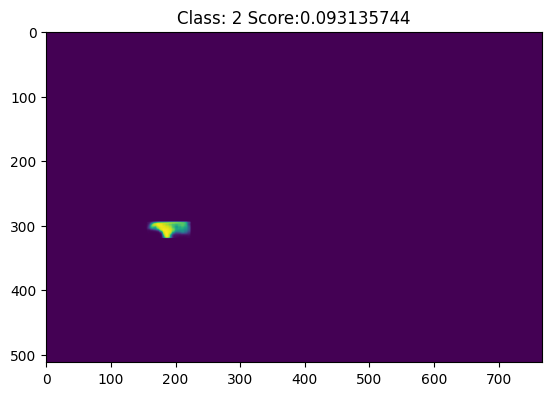

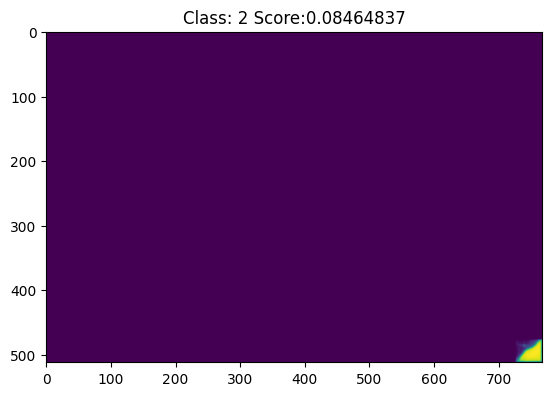

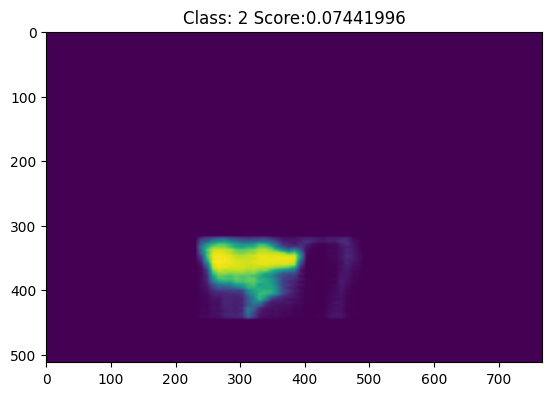

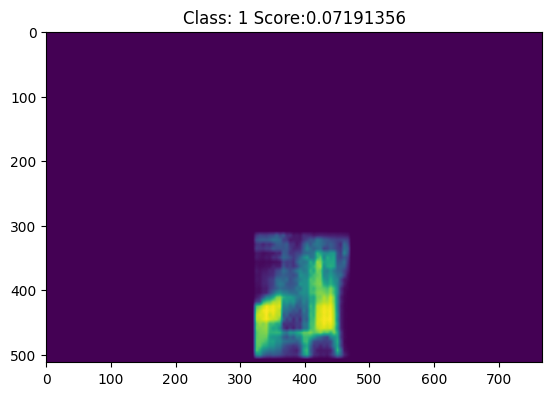

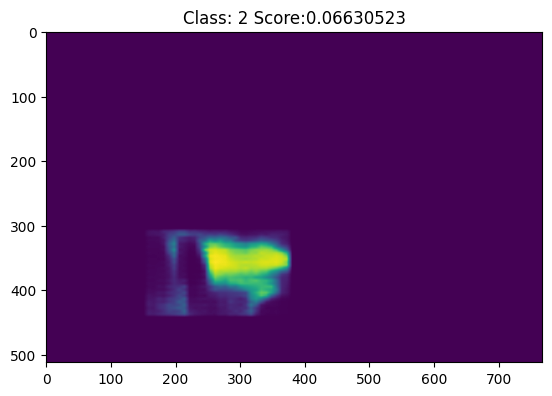

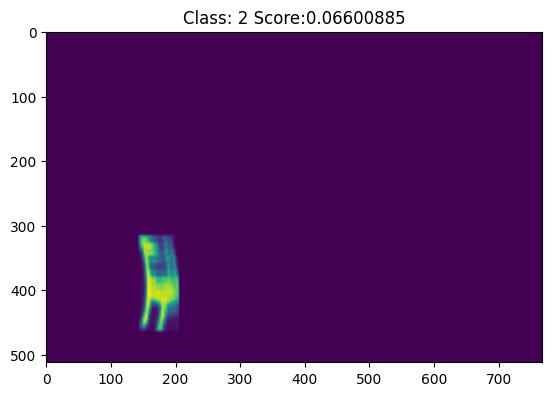

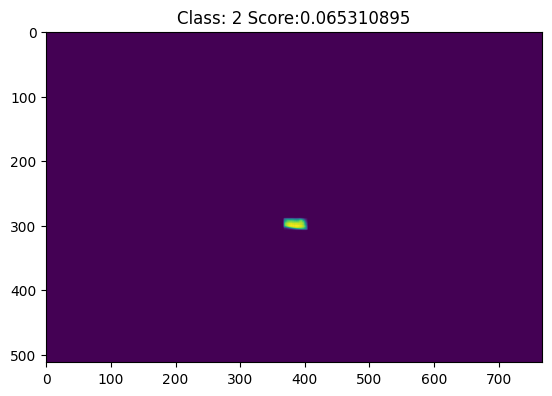

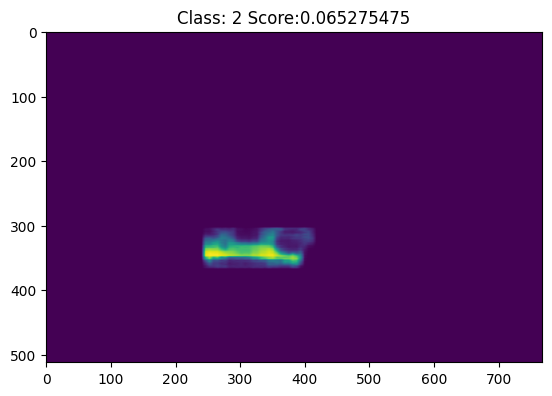

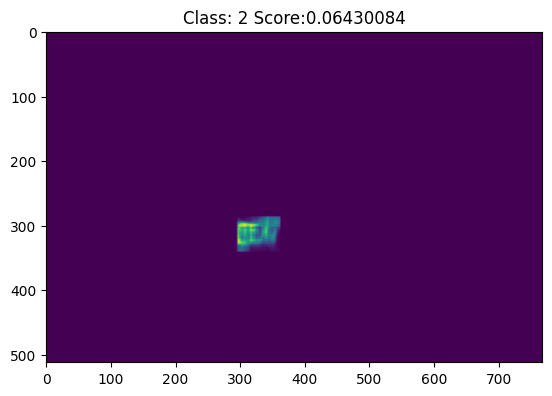

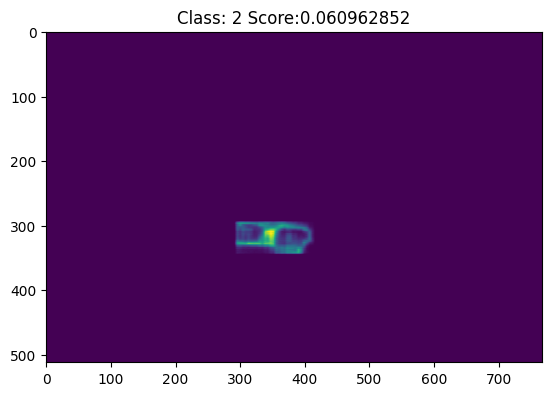

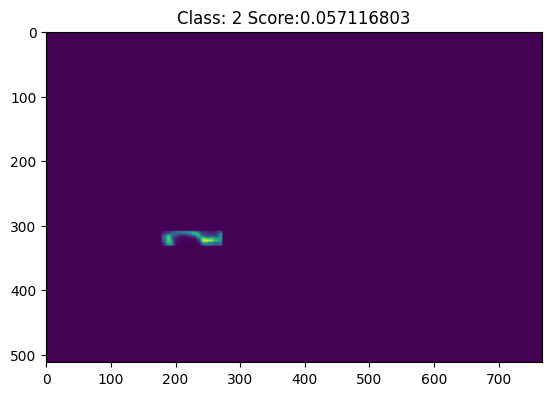

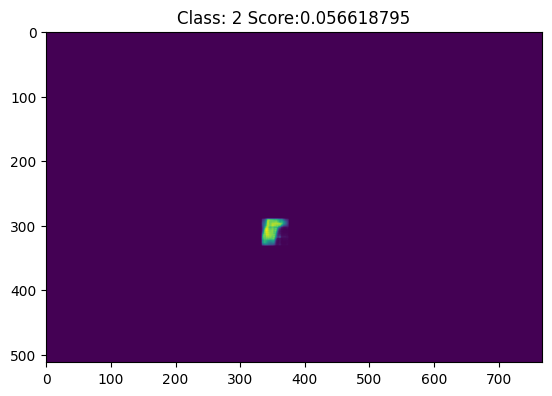

In [54]:
model.eval()
k+=1
im = dataset_test[k][0]
show(im,sz=5)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()